# Importing & Reading

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Image Processing
import cv2
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import mark_boundaries, quickshift

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Model Evaluation
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, precision_score, recall_score, accuracy_score



import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Concatenate, Flatten, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Concatenate, Flatten, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image

2025-11-01 14:57:27.077991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762009047.276922      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762009047.335201      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_images(folder,base_path,categories,image_size):
    images, labels = [], []
    for category in categories:
        path = os.path.join(folder, category)
        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, image_size).astype('float32') / 255.0
                img = np.expand_dims(img, axis=-1)  # add channel dimension
                images.append(img)
                labels.append(category)
    return np.array(images), np.array(labels)

In [3]:
base_path = "/kaggle/input/feature-selelcted-dataset"
categories = ['normal', 'covid19', 'pneumonia']
image_size = (224, 224)

# Load train and full test set
train_images, train_labels = load_images(os.path.join(base_path, 'train'),base_path,categories,image_size)
test_images_full, test_labels_full = load_images(os.path.join(base_path, 'test'),base_path,categories,image_size)

# Split 25% of test into validation (i.e., 5% of total dataset)
val_images, test_images, val_labels, test_labels = train_test_split(
    test_images_full, test_labels_full, test_size=0.75, stratify=test_labels_full, random_state=42
)

# Encode labels
label_mapping = {'covid19': 0, 'pneumonia': 1, 'normal': 2}
def encode_labels(labels):
    int_labels = [label_mapping[label] for label in labels]
    return tf.keras.utils.to_categorical(int_labels, num_classes=3).astype('float32')

train_labels = encode_labels(train_labels)
val_labels = encode_labels(val_labels)
test_labels = encode_labels(test_labels)

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators using flow (for NumPy arrays)
train_generator = train_datagen.flow(
    x=train_images,
    y=train_labels,
    batch_size=16,
    shuffle=True
)

validation_generator = val_test_datagen.flow(
    x=val_images,
    y=val_labels,
    batch_size=16,
    shuffle=True
)

test_generator = val_test_datagen.flow(
    x=test_images,
    y=test_labels,
    batch_size=16,
    shuffle=False
)

In [5]:
test_images.shape

(227, 224, 224, 1)

# Model Initialization

In [57]:
def dense_block(x, filters, num_layers):
    for _ in range(num_layers):
        y = Conv2D(filters, 3, padding='same')(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        x = Concatenate()([x, y])
    return x

# Define the Squeeze Block
def squeeze_block(x, filters_in, filters_mid, filters_out):
    y = Conv2D(filters_in, 1, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters_mid, 1, padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters_out, 3, padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    if x.shape[-1] != filters_out:
        x = Conv2D(filters_out, 1, padding='same')(x)
    return Add()([x, y])

# Build the DCSCNN model
def build_dcscnn(input_shape=(224, 224, 1), num_classes=3):
    inputs = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(64, 5, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Dense Block 1 and Squeeze Block 1
    x = dense_block(x, 128, 2)
    x = squeeze_block(x, 64, 128, 128)
    x = MaxPooling2D(2, strides=2)(x)

    # Dense Block 2 and Squeeze Block 2
    x = dense_block(x, 256, 2)
    x = squeeze_block(x, 128, 256, 256) 
    x = MaxPooling2D(2, strides=2)(x)

    # Dense Block 3 and Squeeze Block 3
    x = dense_block(x, 512, 2) 
    x = squeeze_block(x, 256, 512, 512)
    x = MaxPooling2D(2, strides=2)(x)

    # Dense Block 4 and Squeeze Block 4
    x = dense_block(x, 128, 2)  
    x = squeeze_block(x, 64, 128, 128)

    # Final Convolution
    x = Conv2D(64, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Classification Block
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = build_dcscnn(input_shape=(224, 224, 1), num_classes=3)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 112, 112, 64)   │          1,664 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_44    │ (None, 112, 112, 64)   │            256 │ conv2d_52[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_44             │ (None, 112, 112, 64)   │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 112, 112, 128)  │         73,856 │ activation_44[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_45    │ (None, 112, 112, 128)  │            512 │ conv2d_53[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_45             │ (None, 112, 112, 128)  │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_16            │ (None, 112, 112, 192)  │              0 │ activation_44[0][0],   │
│ (Concatenate)             │                        │                │ activation_45[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 112, 112, 128)  │        221,312 │ concatenate_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_46    │ (None, 112, 112, 128)  │            512 │ conv2d_54[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_46             │ (None, 112, 112, 128)  │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_17            │ (None, 112, 112, 320)  │              0 │ concatenate_16[0][0],  │
│ (Concatenate)             │                        │                │ activation_46[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 112, 112, 64)   │         20,544 │ concatenate_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_47    │ (None, 112, 112, 64)   │            256 │ conv2d_55[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_47        

 Total params: 12,818,723 (48.90 MB)

 Trainable params: 12,809,251 (48.86 MB)

 Non-trainable params: 9,472 (37.00 KB)

In [8]:
history = model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    batch_size=16,
    epochs=50,
    callbacks=[tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')]
)

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 78s 631ms/step - accuracy: 0.6248 - loss: 0.7948 - val_accuracy: 0.3348 - val_loss: 2.9703
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 427ms/step - accuracy: 0.7925 - loss: 0.4728 - val_accuracy: 0.3348 - val_loss: 4.1653
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 435ms/step - accuracy: 0.8275 - loss: 0.4043 - val_accuracy: 0.3524 - val_loss: 2.9237
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 420ms/step - accuracy: 0.8715 - loss: 0.3190 - val_accuracy: 0.3612 - val_loss: 3.5197
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 438ms/step - accuracy: 0.9115 - loss: 0.2385 - val_accuracy: 0.3744 - val_loss: 2.8266
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 433ms/step - accuracy: 0.9182 - loss: 0.2090 - val_accuracy: 0.4758 - val_loss: 1.4428
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 422ms/step - accuracy: 0.8978 - loss: 0.2304 - val_accuracy: 0.4361 - val_loss: 1.7405
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 438ms/step - accuracy: 0.9432 - loss: 0.1235 - val_accu

# Model Testing

In [9]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print('Test acc: ',test_accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 235ms/step - accuracy: 0.8698 - loss: 0.9220
Test acc:  0.8590308427810669


In [10]:
y_pred_probs = model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_labels, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 526ms/step


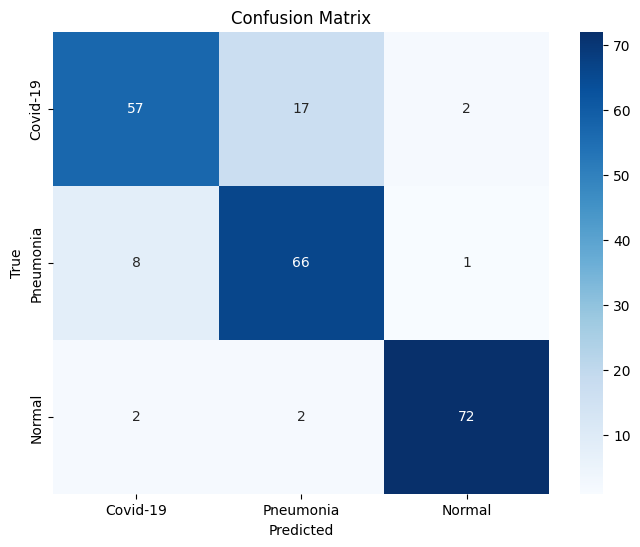

In [11]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Covid-19', 'Pneumonia', 'Normal'], 
            yticklabels=['Covid-19', 'Pneumonia', 'Normal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [12]:
# Assume cm is your confusion matrix
sensitivities = []
specificities = []

for i in range(len(cm)):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FN + FP)

    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Macro-averaged scores
overall_sensitivity = sum(sensitivities) / len(sensitivities)
overall_specificity = sum(specificities) / len(specificities)

print(f"Overall Sensitivity (macro-averaged) = {overall_sensitivity:.2f}")
print(f"Overall Specificity (macro-averaged) = {overall_specificity:.2f}")

Overall Sensitivity (macro-averaged) = 0.86
Overall Specificity (macro-averaged) = 0.93


In [13]:
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Precision: 0.86
Recall: 0.86


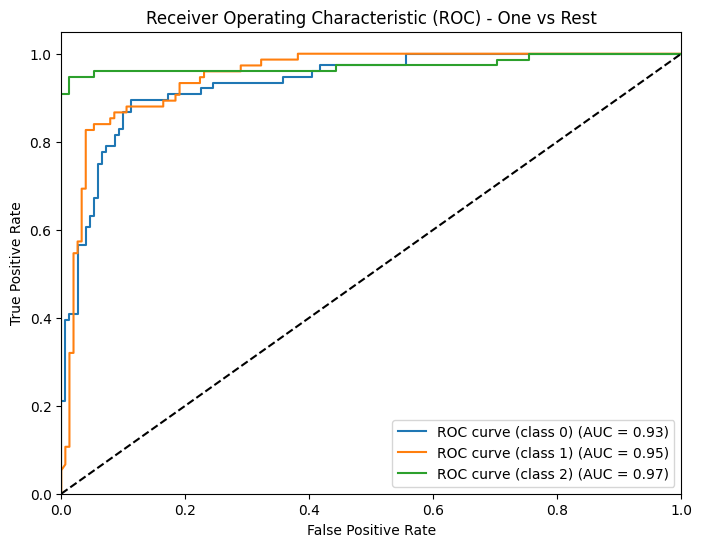

In [14]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - One vs Rest')
plt.legend(loc='lower right')
plt.show()

In [15]:
# Print AUC scores
print("AUC Scores per class:")
for i in range(3):
    print(f"Class {i}: {roc_auc[i]:.2f}")

AUC Scores per class:
Class 0: 0.93
Class 1: 0.95
Class 2: 0.97


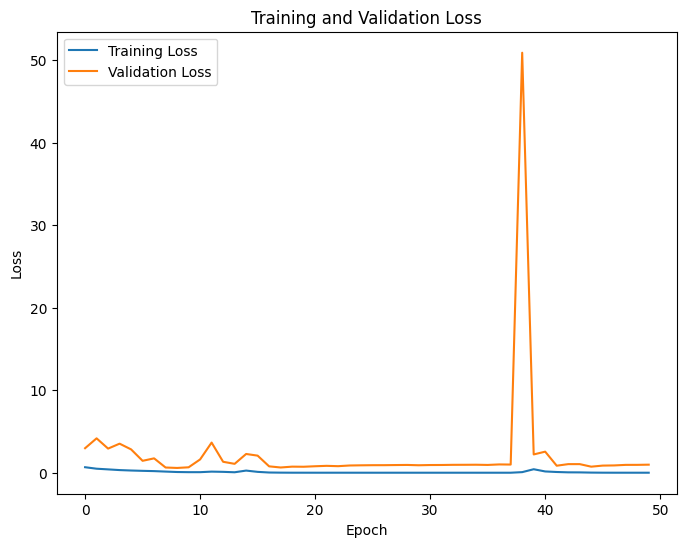

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

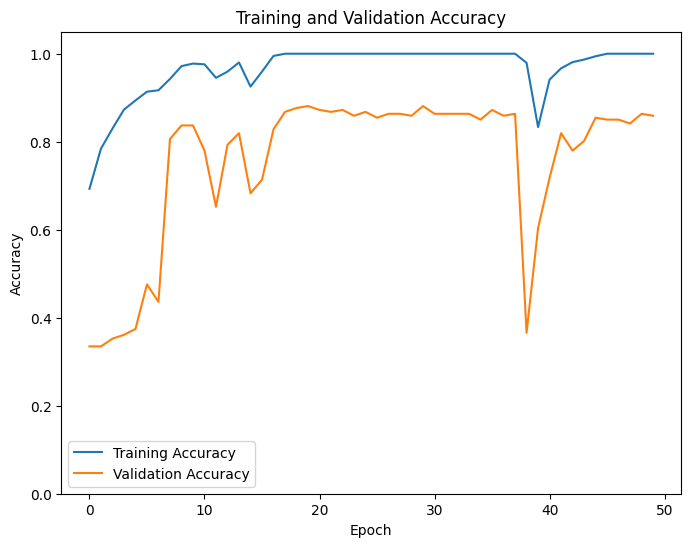

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.05])
plt.legend()
plt.show()

In [16]:
def final_evaluations(best_accuracy, best_history , best_model):
    test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
    print('Test acc: ',test_accuracy)
    y_pred_probs = best_model.predict(test_images)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(test_labels, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Covid-19', 'Pneumonia', 'Normal'], 
                yticklabels=['Covid-19', 'Pneumonia', 'Normal'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(3):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - One vs Rest')
    plt.legend(loc='lower right')
    plt.show()
    # Print AUC scores
    print("AUC Scores per class:")
    for i in range(3):
        print(f"Class {i}: {roc_auc[i]:.2f}")
    plt.figure(figsize=(8, 6))
    plt.plot(best_history.history['accuracy'], label='Training Accuracy')
    plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Simulated Annealing

In [7]:
# Define parameter space
SPACE = {
    "LR": {
        "type": "float",
        "min": 1e-5,
        "max": 1e-2,
        "log": True
    },
    "BATCH": {
        "type": "int",
        "min": 4,
        "max": 256,
        "step": 4
    },
    "DROPOUT": {
        "type": "float",
        "min": 0,
        "max": 0.8,
        "step": 0.1
    },
    "DENSE1": {
        "type": "int",
        "min": 16,
        "max": 1024,
        "step": 16
    },
    "DENSE2": {
        "type": "int",
        "min": 16,
        "max": 512,
        "step": 16
    }
}

# Starting configuration
START = {
    "LR": 1e-3,
    "BATCH": 8,
    "DROPOUT": 0,
    "DENSE1": 32,
    "DENSE2": 16
}

In [8]:
def _clip_round(name, val):
    """Clip and round value to valid range"""
    spec = SPACE[name]
    
    if spec["type"] == "int":
        v = int(round(val))
        return int(max(spec["min"], min(spec["max"], v)))
    
    if spec["type"] == "float":
        if spec.get("log", False):
            log_min = np.log10(spec["min"])
            log_max = np.log10(spec["max"])
            log_val = np.log10(max(spec["min"], min(spec["max"], float(val))))
            log_val = max(log_min, min(log_max, log_val))
            v = 10 ** log_val
        else:
            v = float(max(spec["min"], min(spec["max"], float(val))))
        
        step = spec.get("step", None)
        if step is not None and step > 0:
            v = round(v / step) * step
            v = float(max(spec["min"], min(spec["max"], v)))
        else:
            precision = spec.get("precision", 6)
            v = round(v, precision)
        
        return v


def _random_neighbor(cfg):
    """Generate random neighbor by modifying one parameter"""
    name = random.choice(list(SPACE.keys()))
    spec = SPACE[name]
    new_cfg = cfg.copy()
    
    if spec["type"] == "int":
        step = spec["step"]
        delta = random.choice([-step, step])
        new_cfg[name] = _clip_round(name, cfg[name] + delta)
    
    elif spec["type"] == "float":
        if spec.get("log", False):
            # Log scale perturbation
            log_min = np.log10(spec["min"])
            log_max = np.log10(spec["max"])
            log_val = np.log10(cfg[name])
            step_size = (log_max - log_min) * 0.1  
            delta = random.choice([-step_size, step_size])
            new_val = 10 ** (log_val + delta)
        else:
            step = spec.get("step", 0.01)
            delta = random.choice([-step, step])
            new_val = cfg[name] + delta
        
        new_cfg[name] = _clip_round(name, new_val)
    
    return new_cfg, name

In [9]:
def evaluate_parameters(candidate, X_train, y_train, X_val, y_val, epochs):
    """
    Builds and evaluates a model with given hyperparameters.
    Returns training accuracy, validation accuracy, and model.
    """
    print("EVALUATING MODEL WITH PARAMETERS:")
    print(f"  Learning Rate: {candidate['LR']:.6f}")
    print(f"  Batch Size: {candidate['BATCH']}")
    print(f"  Dropout: {candidate['DROPOUT']:.2f}")
    print(f"  Dense1: {candidate['DENSE1']}")
    print(f"  Dense2: {candidate['DENSE2']}")
    
    try:
        def dense_block(x, filters, num_layers):
            for _ in range(num_layers):
                y = Conv2D(filters, 3, padding='same')(x)
                y = BatchNormalization()(y)
                y = Activation('relu')(y)
                x = Concatenate()([x, y])
            return x
        
        def squeeze_block(x, filters_in, filters_mid, filters_out):
            y = Conv2D(filters_in, 1, padding='same')(x)
            y = BatchNormalization()(y)
            y = Activation('relu')(y)
            y = Conv2D(filters_mid, 1, padding='same')(y)
            y = BatchNormalization()(y)
            y = Activation('relu')(y)
            y = Conv2D(filters_out, 3, padding='same')(y)
            y = BatchNormalization()(y)
            y = Activation('relu')(y)
            if x.shape[-1] != filters_out:
                x = Conv2D(filters_out, 1, padding='same')(x)
            return Add()([x, y])
        
        def build_dcscnn(input_shape=(224, 224, 1), num_classes=3):
            inputs = Input(shape=input_shape)
            x = Conv2D(64, 5, strides=2, padding='same')(inputs)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = dense_block(x, 128, 2)
            x = squeeze_block(x, 64, 128, 128)
            x = MaxPooling2D(2, strides=2)(x)
            x = dense_block(x, 256, 2)
            x = squeeze_block(x, 128, 256, 256)
            x = MaxPooling2D(2, strides=2)(x)
            x = dense_block(x, 512, 2)
            x = squeeze_block(x, 256, 512, 512)
            x = MaxPooling2D(2, strides=2)(x)
            x = dense_block(x, 128, 2)
            x = squeeze_block(x, 64, 128, 128)
            x = Conv2D(64, 1, padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Flatten()(x)
            x = Dense(candidate['DENSE1'], activation='relu')(x)
            x = Dropout(candidate['DROPOUT'])(x)
            x = Dense(candidate['DENSE2'], activation='relu')(x)
            outputs = Dense(num_classes, activation='softmax')(x)
            return Model(inputs, outputs)
        
        model = build_dcscnn(input_shape=(224, 224, 1), num_classes=3)
        model.compile(optimizer=Adam(learning_rate=candidate['LR']),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        print("\nTraining model...")
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=candidate['BATCH'],
            epochs=epochs,
            verbose=0, 
            callbacks=[tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')]
        )

        train_accuracy = history.history['accuracy'][-1]
        val_accuracy = history.history['val_accuracy'][-1]
        print(f"\nTrain Accuracy: {train_accuracy:.4f} | Validation Accuracy: {val_accuracy:.4f}")

        return train_accuracy, val_accuracy, history, model

    except Exception as e:
        print(f"\nError during training: {e}")
        return 0.0, 0.0, None, None


In [10]:
def simulated_annealing(X_train, y_train, X_val, y_val, epochs, iters=20, T0=1.0, alpha=0.95):
    print("STARTING SIMULATED ANNEALING")
    
    current_solution = START.copy()
    print("\nInitializing with starting parameters:")
    for key, val in current_solution.items():
        print(f"  {key}: {val}")

    train_acc, val_acc, _, _ = evaluate_parameters(current_solution, X_train, y_train, X_val, y_val, epochs)
    current_gap = abs(train_acc - val_acc)
    current_fitness = 0.7 * val_acc + 0.3 * (1 - current_gap)  # weighted fitness
    
    best_solution = current_solution.copy()
    best_fitness = current_fitness
    best_val_acc = val_acc
    
    T = T0
    history = []

    for iteration in range(iters):
        print(f"\nITERATION {iteration + 1}/{iters}")
        print(f"Temperature: {T:.4f}")
        print(f"Current Fitness: {current_fitness:.4f} | Best Fitness: {best_fitness:.4f}")
        
        candidate, changed_param = _random_neighbor(current_solution)
        print(f"Changing parameter {changed_param}: {current_solution[changed_param]} → {candidate[changed_param]}")
        
        cand_train_acc, cand_val_acc, _, _ = evaluate_parameters(candidate, X_train, y_train, X_val, y_val, epochs)
        cand_gap = abs(cand_train_acc - cand_val_acc)
        cand_fitness = 0.7 * cand_val_acc + 0.3 * (1 - cand_gap)
        
        delta = cand_fitness - current_fitness
        print(f"Fitness Change: {delta:.4f} | Candidate Fitness: {cand_fitness:.4f}")
        
        if delta > 0:
            print("ACCEPTED: Better fitness!")
            current_solution = candidate
            current_fitness = cand_fitness
        else:
            prob = np.exp(delta / T) if T > 0 else 0
            if np.random.rand() < prob:
                print("ACCEPTED: Worse solution accepted probabilistically!")
                current_solution = candidate
                current_fitness = cand_fitness
            else:
                print("REJECTED: Worse solution rejected.")
        
        if current_fitness > best_fitness:
            print("\nNEW BEST SOLUTION FOUND!")
            best_solution = current_solution.copy()
            best_fitness = current_fitness
            best_val_acc = cand_val_acc
        
        history.append(best_fitness)
        T *= alpha

    print("\n=== SIMULATED ANNEALING COMPLETED ===")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Best Fitness Score: {best_fitness:.4f}")
    print("Best Parameters:")
    for k, v in best_solution.items():
        print(f"  {k}: {v}")
    
    return best_solution, best_fitness, history

In [11]:
import random
best_params, best_acc, history = simulated_annealing(
    train_images, train_labels, test_images, test_labels, 10,
    iters=10,
    T0=1.0,
    alpha=0.95
)

print("\nOptimization History (Best Accuracy at each iteration):")
for i, acc in enumerate(history):
    print(f"  Iteration {i+1}: {acc:.4f}")

STARTING SIMULATED ANNEALING

Initializing with starting parameters:
  LR: 0.001
  BATCH: 8
  DROPOUT: 0
  DENSE1: 32
  DENSE2: 16
EVALUATING MODEL WITH PARAMETERS:
  Learning Rate: 0.001000
  Batch Size: 8
  Dropout: 0.00
  Dense1: 32
  Dense2: 16


I0000 00:00:1761902732.526743      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761902732.527489      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Training model...


I0000 00:00:1761902755.610528      92 service.cc:148] XLA service 0x7bd4f4001880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761902755.611296      92 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761902755.611318      92 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761902757.585054      92 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761902789.946487      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Train Accuracy: 0.9602 | Validation Accuracy: 0.8590

ITERATION 1/10
Temperature: 1.0000
Current Fitness: 0.8710 | Best Fitness: 0.8710
Changing parameter DENSE2: 16 → 16
EVALUATING MODEL WITH PARAMETERS:
  Learning Rate: 0.001000
  Batch Size: 8
  Dropout: 0.00
  Dense1: 32
  Dense2: 16

Training model...

Train Accuracy: 0.9245 | Validation Accuracy: 0.8018
Fitness Change: -0.0466 | Candidate Fitness: 0.8244
ACCEPTED: Worse solution accepted probabilistically!

ITERATION 2/10
Temperature: 0.9500
Current Fitness: 0.8244 | Best Fitness: 0.8710
Changing parameter LR: 0.001 → 0.000501
EVALUATING MODEL WITH PARAMETERS:
  Learning Rate: 0.000501
  Batch Size: 8
  Dropout: 0.00
  Dense1: 32
  Dense2: 16

Training model...

Train Accuracy: 0.9801 | Validation Accuracy: 0.8062
Fitness Change: -0.0123 | Candidate Fitness: 0.8121
REJECTED: Worse solution rejected.

ITERATION 3/10
Temperature: 0.9025
Current Fitness: 0.8244 | Best Fitness: 0.8710
Changing parameter DENSE1: 32 → 48
EVALUATING MO

In [12]:
best_accuracy, best_val,  best_history , best_model,  = evaluate_parameters(best_params,  train_images, train_labels, test_images, test_labels, 10)

EVALUATING MODEL WITH PARAMETERS:
  Learning Rate: 0.000501
  Batch Size: 8
  Dropout: 0.00
  Dense1: 48
  Dense2: 16

Training model...

Train Accuracy: 1.0000 | Validation Accuracy: 0.8987


ValueError: too many values to unpack (expected 3)

In [13]:
best_accuracy, best_val,  best_history , best_model,  = evaluate_parameters(best_params,  train_images, train_labels, test_images, test_labels, 10)

EVALUATING MODEL WITH PARAMETERS:
  Learning Rate: 0.000501
  Batch Size: 8
  Dropout: 0.00
  Dense1: 48
  Dense2: 16

Training model...

Train Accuracy: 0.9809 | Validation Accuracy: 0.8811


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.8734 - loss: 0.5457
Test acc:  0.8810572624206543
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 527ms/step


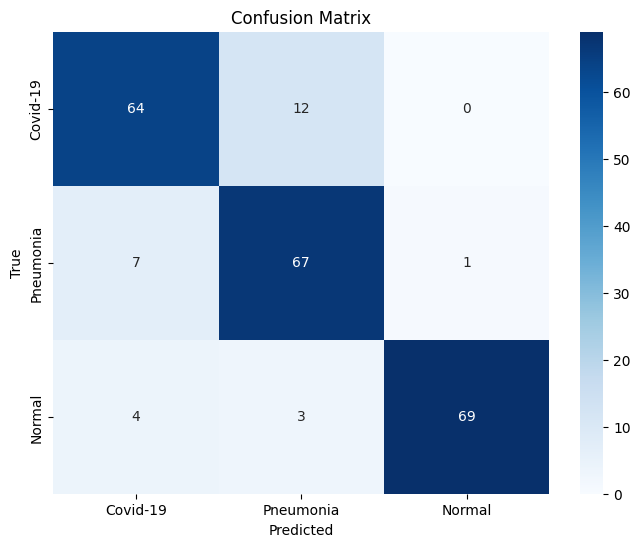

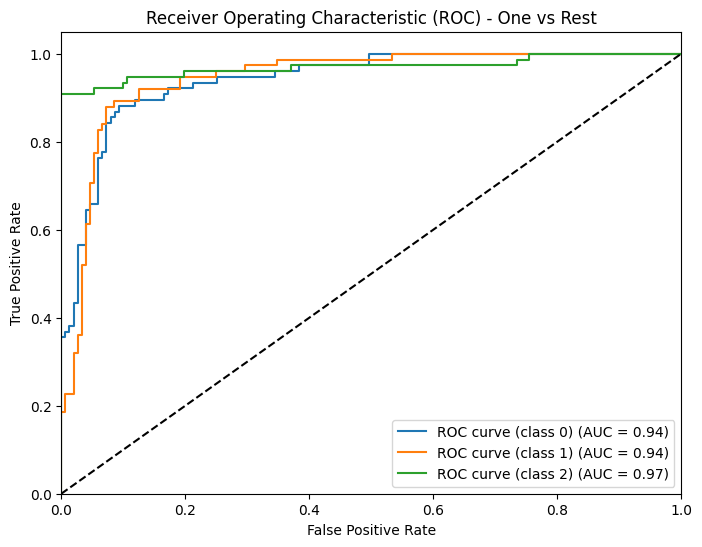

AUC Scores per class:
Class 0: 0.94
Class 1: 0.94
Class 2: 0.97


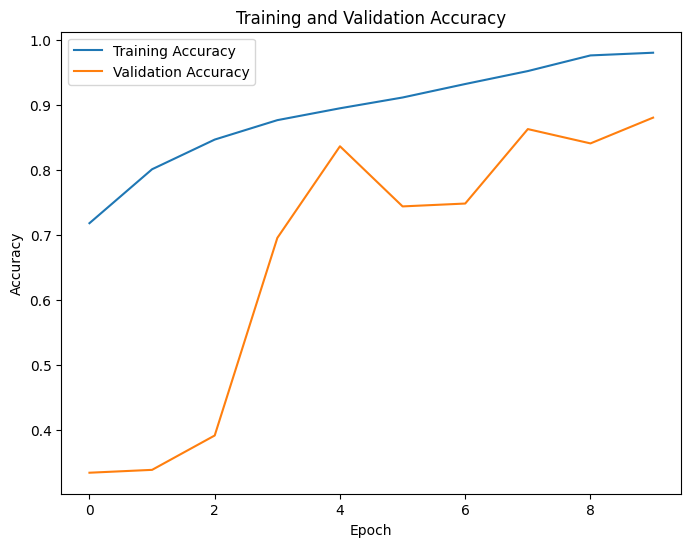

In [17]:
final_evaluations(best_accuracy, best_history , best_model)

## Particle Swarm Optimization

In [58]:
bounds = [
    (1e-5, 1e-2, 'log'),       # 0: lr
    (8, 64, 'int'),            # 1: batch
    (0.0, 0.5, 'linear'),      # 2: dropout
    (32, 256, 'int'),           # 3: dense_units
    (16, 128, 'int')# 4: dense_units
    
]

In [59]:
class Particle:
    def __init__(self, bounds):
        self.pos=[]; self.vel=[]
        for lo,hi,t in bounds:
            if t=='log': val=10**np.random.uniform(np.log10(lo), np.log10(hi))
            elif t=='int': val=np.random.randint(lo, hi+1)
            else: val=np.random.uniform(lo,hi)
            self.pos.append(val); self.vel.append(0.0)
        self.best_pos=self.pos.copy(); self.best_score=-1e9


def enforce(idx, val):
    lo,hi,t = bounds[idx]
    if t=='int':
        v=int(round(val)); v=max(lo,min(hi,v)); return v
    if t=='log' or t=='linear':
        v=float(val); v=max(lo,min(hi,v)); return v
    return val

In [60]:
def dense_block(x, filters, num_layers):
        for _ in range(num_layers):
            y = Conv2D(filters, 3, padding='same')(x)
            y = BatchNormalization()(y)
            y = Activation('relu')(y)
            x = Concatenate()([x, y])
        return x
    
def squeeze_block(x, filters_in, filters_mid, filters_out):
    y = Conv2D(filters_in, 1, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters_mid, 1, padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters_out, 3, padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    if x.shape[-1] != filters_out:
        x = Conv2D(filters_out, 1, padding='same')(x)
    return Add()([x, y])

def build_dcscnn(dropout_rate,  dense_units_1, dense_units_2 , input_shape=(224, 224, 1), num_classes=3):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, 5, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Dense Block 1 and Squeeze Block 1
    x = dense_block(x, 128, 2)
    x = squeeze_block(x, 64, 128, 128)
    x = MaxPooling2D(2, strides=2)(x)

    # Dense Block 2 and Squeeze Block 2
    x = dense_block(x, 256, 2)
    x = squeeze_block(x, 128, 256, 256) 
    x = MaxPooling2D(2, strides=2)(x)

    # Dense Block 3 and Squeeze Block 3
    x = dense_block(x, 512, 2) 
    x = squeeze_block(x, 256, 512, 512)
    x = MaxPooling2D(2, strides=2)(x)

    # Dense Block 4 and Squeeze Block 4
    x = dense_block(x, 128, 2)  
    x = squeeze_block(x, 64, 128, 128)

    # Final Convolution
    x = Conv2D(64, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Classification Block
    x = Flatten()(x)
    x = Dense(dense_units_1, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units_2, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [61]:
def create_pso_model(input_shape, num_classes, dropout_rate, learning_rate, dense_units_1, dense_units_2 ):

    model = build_dcscnn(dropout_rate,  dense_units_1, dense_units_2 ,input_shape=(224, 224, 1), num_classes=3)
    model.compile(optimizer=Adam(learning_rate = learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [62]:
def eval_particle(particle, train_images, train_labels, test_images, test_labels, epochs):
    lr = particle.pos[0]
    batch = int(round(particle.pos[1]))
    dropout = particle.pos[2]
    dense_units_1 = int(round(particle.pos[3]))
    dense_units_2 = int(round(particle.pos[4]))

    input_shape = train_images.shape[1:]
    num_classes = train_labels.shape[1]

    m = create_pso_model(input_shape, num_classes, dropout, lr, dense_units_1,dense_units_2 )
    history = model.fit(
        train_images, train_labels,
        validation_data=(test_images, test_labels),
        batch_size=batch,
        epochs=epochs,
        callbacks=[tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')],
        verbose = 1
    )
   
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]

    del m
    tf.keras.backend.clear_session()

    return train_acc, val_acc

In [63]:
num_particles = 10
max_iter = 5
w, c1, c2 = 0.5, 1.0, 1.0
epochs = 10
swarm = [Particle(bounds) for _ in range(num_particles)]
gbest_pos=None; gbest_score=-1e9

In [64]:
def acceptance_score(train_acc_curr, val_acc_curr, train_acc_prev, val_acc_prev, w_gap=0.7, w_val=0.3):

    delta_val = val_acc_curr - val_acc_prev
    delta_gap = ((train_acc_curr - val_acc_curr) - (train_acc_prev - val_acc_prev))
    
    score = w_val * delta_val - w_gap * delta_gap
    return score


In [ ]:
prev_train_acc, prev_val_acc = 0, 0  

for it in range(max_iter):
    print('PSO iter', it+1)

    for i, p in enumerate(swarm):
        train_acc, val_acc = eval_particle(p, train_images, train_labels, test_images, test_labels, epochs)

        print(f'  particle {i} -> val_accuracy {val_acc:.4f}, train_accuracy {train_acc:.4f}')
        print(f'   LR={p.pos[0]:.2e}, Dropout={p.pos[2]:.2f}, Epochs={int(round(p.pos[3]))}, Batch={int(round(p.pos[1]))}')

        score = acceptance_score(train_acc, val_acc, prev_train_acc, prev_val_acc)
        prev_train_acc, prev_val_acc = train_acc, val_acc 

        if score > 0:  
            if val_acc > p.best_score:
                p.best_score = val_acc
                p.best_pos = p.pos.copy()
            
            if val_acc > gbest_score:
                gbest_score = val_acc
                gbest_pos = p.pos.copy()


PSO iter 1
Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 124s 633ms/step - accuracy: 0.6089 - loss: 1.0629 - val_accuracy: 0.3348 - val_loss: 2.1892
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 34s 415ms/step - accuracy: 0.7570 - loss: 0.5452 - val_accuracy: 0.3348 - val_loss: 4.1113
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 391ms/step - accuracy: 0.8346 - loss: 0.3865 - val_accuracy: 0.3348 - val_loss: 4.4448
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 393ms/step - accuracy: 0.8589 - loss: 0.3128 - val_accuracy: 0.3348 - val_loss: 3.7039
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 399ms/step - accuracy: 0.8926 - loss: 0.2523 - val_accuracy: 0.3612 - val_loss: 2.8707
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 408ms/step - accuracy: 0.9258 - loss: 0.1841 - val_accuracy: 0.4626 - val_loss: 1.8978
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 407ms/step - accuracy: 0.9322 - loss: 0.1748 - val_accuracy: 0.7004 - val_loss: 0.9474
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 396ms/step - accuracy: 0.9405 - loss: 0.140

In [ ]:
best_params = 
{
    "LR": 0.000501,
    "BATCH": 12,
    "DROPOUT": 0.00,
    "DENSE1": 48,
    "DENSE2": 16
}

In [ ]:
best_accuracy, best_history , best_model  = evaluate_parameters(best_params,  train_images, train_labels, test_images, test_labels, 50)

In [ ]:
final_evaluations(best_accuracy, best_history , best_model)

## Ant Colony 

In [6]:
Best = {
    "LR": 0.000501,
    "BATCH": 8,
    "DROPOUT": 0.00,
    "DENSE1": 64,
    "DENSE2": 48
}



In [7]:
def build_and_evaluate(solution, X_train_features, X_val_features, y_train, y_val, num_classes, epochs, Best):
    """Trains FFN on selected subset of features and returns train acc, val acc, and mask."""
    
    selected = np.array([int(v) for v in solution.values()])
    mask = selected.astype(bool)

    if np.sum(mask) == 0:
        return 0.0, 0.0, mask  

    X_train_sel = X_train_features[:, mask]
    X_val_sel = X_val_features[:, mask]

    input_dim = X_train_sel.shape[1]

    # Define FFN
    inputs = Input(shape=(input_dim,))
    x = Dense(Best["DENSE1"], activation='relu')(inputs)
    x = Dropout(Best['DROPOUT'])(x)
    x = Dense(Best["DENSE2"], activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    ffn_model = Model(inputs, outputs)

    ffn_model.compile(
        optimizer=Adam(learning_rate=Best["LR"]),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = ffn_model.fit(
        X_train_sel, y_train,
        validation_data=(X_val_sel, y_val),
        epochs=epochs,
        batch_size=Best['BATCH'],
        verbose=1
    )

    train_acc = max(history.history['accuracy'])
    val_acc = max(history.history['val_accuracy'])

    return train_acc, val_acc, mask


In [8]:
def dense_block(x, filters, num_layers):
    for _ in range(num_layers):
        y = Conv2D(filters, 3, padding='same')(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        x = Concatenate()([x, y])
    return x

# Define the Squeeze Block
def squeeze_block(x, filters_in, filters_mid, filters_out):
    y = Conv2D(filters_in, 1, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters_mid, 1, padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters_out, 3, padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    if x.shape[-1] != filters_out:
        x = Conv2D(filters_out, 1, padding='same')(x)
    return Add()([x, y])

# Build the DCSCNN model
def build_dcscnn(Best, input_shape=(224, 224, 1), num_classes=3):
    inputs = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(64, 5, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Dense Block 1 and Squeeze Block 1
    x = dense_block(x, 128, 2)
    x = squeeze_block(x, 64, 128, 128)
    x = MaxPooling2D(2, strides=2)(x)

    # Dense Block 2 and Squeeze Block 2
    x = dense_block(x, 256, 2)
    x = squeeze_block(x, 128, 256, 256) 
    x = MaxPooling2D(2, strides=2)(x)

    # Dense Block 3 and Squeeze Block 3
    x = dense_block(x, 512, 2) 
    x = squeeze_block(x, 256, 512, 512)
    x = MaxPooling2D(2, strides=2)(x)

    # Dense Block 4 and Squeeze Block 4
    x = dense_block(x, 128, 2)  
    x = squeeze_block(x, 64, 128, 128)

    # Final Convolution
    x = Conv2D(64, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Classification Block
    x = Flatten(name='flatten')(x)
    x = Dense(Best['DENSE1'], activation='relu')(x)
    x = Dropout(Best['DROPOUT'])(x)
    x = Dense(Best['DENSE2'], activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model



In [9]:
import random


num_classes = 3
cnn_model = build_dcscnn(Best, input_shape=(224, 224, 1), num_classes=num_classes)
cnn_model.compile(optimizer=Adam(learning_rate=Best["LR"]), loss='categorical_crossentropy', metrics=['accuracy'])

feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('flatten').output)


X_train_features = feature_extractor.predict(train_images)
X_val_features = feature_extractor.predict(test_images)

num_features = X_train_features.shape[1]
print(f"Extracted {num_features} features from CNN backbone.")

I0000 00:00:1761910740.674443      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761910740.675234      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1761910743.957974      94 service.cc:148] XLA service 0x7be968049bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761910743.958661      94 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761910743.958680      94 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761910744.243283      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/38 ━━━━━━━━━━━━━━━━━━━━ 12:41 21s/step

I0000 00:00:1761910763.652938      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 46s 675ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step  
Extracted 12544 features from CNN backbone.


In [10]:
def run_aco_feature_selection(X_train_features, X_val_features, y_train, y_val, 
                              num_features, num_classes, Best,epochs_aco,
                              n_ants=5, n_iterations=5, evaporation_rate=0.1,
                              alpha=0.7, beta=0.3):
    """
    Runs Ant Colony Optimization (ACO) for feature selection.
    Combines validation accuracy and generalization (train-val gap) in fitness.
    Returns:
        best_solution (dict): binary feature selection mask
        best_fitness (float): best fitness score achieved
    """

    import random

    # Initialize pheromones
    search_space_discrete = {f'f{i}': [0, 1] for i in range(num_features)}
    pheromones = {key: {val: 1.0 for val in values} for key, values in search_space_discrete.items()}
    param_keys = list(search_space_discrete.keys())

    best_solution = None
    best_fitness = -float("inf")

    print("\n--- Starting ACO Feature Selection ---")

    for iteration in range(n_iterations):
        print(f"\n--- Iteration {iteration + 1}/{n_iterations} ---")
        ant_solutions_this_iter = []

        for ant in range(n_ants):
            current_solution = {}

            # Construct feature subset for this ant
            for key in param_keys:
                choices = list(pheromones[key].keys())
                scores = list(pheromones[key].values())
                total_pheromone = sum(scores)
                probabilities = [s / total_pheromone for s in scores]
                chosen_value = random.choices(choices, weights=probabilities, k=1)[0]
                current_solution[key] = chosen_value

            # Build and evaluate model
            train_acc, val_acc, _ = build_and_evaluate(
                current_solution,
                X_train_features, X_val_features,
                y_train, y_val,
                num_classes, epochs_aco,
                Best
            )


            # Compute fitness with generalization penalty
            acc_gap = abs(train_acc - val_acc)
            fitness = alpha * val_acc - beta * acc_gap

            print(f"\tAnt {ant + 1}/{n_ants} | Val: {val_acc:.4f} | Train: {train_acc:.4f} | Gap: {acc_gap:.4f} | Fitness: {fitness:.4f}")

            ant_solutions_this_iter.append((current_solution, fitness))

            # Update global best
            if fitness > best_fitness:
                best_fitness = fitness
                best_solution = current_solution
                print(f"\t*** New Global Best! Fitness: {fitness:.4f} ***")

        # --- Pheromone Update ---
        for key, values in pheromones.items():
            for val in values:
                pheromones[key][val] *= (1.0 - evaporation_rate)

        # Deposit pheromone on the best ant of this iteration
        ant_solutions_this_iter.sort(key=lambda x: x[1], reverse=True)
        best_ant_solution, best_ant_fitness = ant_solutions_this_iter[0]
        for key, value in best_ant_solution.items():
            pheromones[key][value] += best_ant_fitness

        print(f"\tIteration Best Fitness: {best_ant_fitness:.4f}")
        print(f"\tGlobal Best Fitness: {best_fitness:.4f}")

    print("\n--- ACO Finished ---")
    print(f"Best fitness: {best_fitness:.4f}")
    print(f"Selected features: {sum([int(v) for v in best_solution.values()])}/{num_features}")

    return best_solution, best_fitness


In [11]:
best_solution, best_fitness = run_aco_feature_selection(
    X_train_features,
    X_val_features,
    train_labels,
    test_labels,
    num_features,
    num_classes,
    Best ,
    epochs_aco=10,    
    n_ants=10,
    n_iterations=10
)


--- Starting ACO Feature Selection ---

--- Iteration 1/10 ---
Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5390 - loss: 0.9427 - val_accuracy: 0.6960 - val_loss: 0.6922
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6628 - loss: 0.6496 - val_accuracy: 0.7401 - val_loss: 0.5797
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6981 - loss: 0.5986 - val_accuracy: 0.7137 - val_loss: 0.5837
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7726 - loss: 0.5245 - val_accuracy: 0.7577 - val_loss: 0.5341
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7823 - loss: 0.4881 - val_accuracy: 0.7665 - val_loss: 0.5527
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8084 - loss: 0.4205 - val_accuracy: 0.7357 - val_loss: 0.5729
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8011 - loss: 0.4259 - val_accuracy: 0.7885 - val_loss: 0.5058
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━

In [15]:
best_ant = best_solution

# Tabu Search

In [6]:
def dense_block(x, filters, num_layers):
    for _ in range(num_layers):
        y = Conv2D(filters, 3, padding='same')(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        x = Concatenate()([x, y])
    return x

# Define the Squeeze Block
def squeeze_block(x, filters_in, filters_mid, filters_out):
    y = Conv2D(filters_in, 1, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters_mid, 1, padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters_out, 3, padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    if x.shape[-1] != filters_out:
        x = Conv2D(filters_out, 1, padding='same')(x)
    return Add()([x, y])

# Build the DCSCNN model
def build_dcscnn(dropout_rate, dense_units_1, dense_units_2, input_shape=(224, 224, 1), num_classes=3):
    inputs = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(64, 5, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Dense Block 1 and Squeeze Block 1
    x = dense_block(x, 128, 2)
    x = squeeze_block(x, 64, 128, 128)
    x = MaxPooling2D(2, strides=2)(x)

    # Dense Block 2 and Squeeze Block 2
    x = dense_block(x, 256, 2)
    x = squeeze_block(x, 128, 256, 256) 
    x = MaxPooling2D(2, strides=2)(x)

    # Dense Block 3 and Squeeze Block 3
    x = dense_block(x, 512, 2) 
    x = squeeze_block(x, 256, 512, 512)
    x = MaxPooling2D(2, strides=2)(x)

    # Dense Block 4 and Squeeze Block 4
    x = dense_block(x, 128, 2)  
    x = squeeze_block(x, 64, 128, 128)

    # Final Convolution
    x = Conv2D(64, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Classification Block
    x = Flatten(name='flatten')(x)
    x = Dense(dense_units_1, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units_2, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model



In [7]:
previous_best = {
    "val_acc": 0.0,
    "gap": float("inf")
}

def evaluate_solution(solution_params, epochs=5, overfit_penalty_factor=0.5,
                      alpha=0.7, beta=0.3):
    """
    Builds, compiles, and trains a model.
    Returns a weighted score that rewards improvement in validation accuracy
    and penalizes overfitting (train-val gap).

    alpha: weight for validation accuracy improvement
    beta:  weight for generalization improvement (smaller gap)
    """
    global previous_best

    print(f"--- Evaluating: {solution_params} ---")

    tf.keras.backend.clear_session()

    try:
        batch_size = int(solution_params['batch_size'])
        learning_rate = float(solution_params['learning_rate'])
        dense_units_1 = int(solution_params['dense_units_1'])
        dense_units_2 = int(solution_params['dense_units_2'])
        dropout_rate = float(solution_params['dropout_rate'])

        model = build_dcscnn(dropout_rate, dense_units_1, dense_units_2, 
                             input_shape=(224, 224, 1), num_classes=3)
        model.compile(optimizer=Adam(learning_rate=learning_rate), 
                      loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(
            train_images, train_labels,
            validation_data=(test_images, test_labels),
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            callbacks=[tf.keras.callbacks.ModelCheckpoint('best_model.keras', 
                                                          save_best_only=True, 
                                                          monitor='val_loss')]
        )

        val_accs = history.history['val_accuracy']
        train_accs = history.history['accuracy']
        best_epoch = np.argmax(val_accs)

        best_val_acc = val_accs[best_epoch]
        train_acc_at_best = train_accs[best_epoch]
        overfit_gap = max(0, train_acc_at_best - best_val_acc)

        val_improvement = best_val_acc - previous_best["val_acc"]
        gap_improvement = previous_best["gap"] - overfit_gap  

        val_improvement = max(val_improvement, 0)
        gap_improvement = max(gap_improvement, 0)

        score = (alpha * best_val_acc) + (beta * (val_improvement + gap_improvement)) - (overfit_penalty_factor * overfit_gap)

        if best_val_acc > previous_best["val_acc"]:
            previous_best["val_acc"] = best_val_acc
        if overfit_gap < previous_best["gap"]:
            previous_best["gap"] = overfit_gap

        print(f"ValAcc={best_val_acc:.4f}, TrainAcc={train_acc_at_best:.4f}, Gap={overfit_gap:.4f}")
        print(f"ΔVal={val_improvement:.4f}, ΔGap={gap_improvement:.4f}, Final Score={score:.4f}")
        print(f"Updated bests: {previous_best}")

        return score

    except Exception as e:
        print(f"Error evaluating {solution_params}: {e}")
        return 0.0


In [8]:
def get_neighborhood(current_solution, search_space):
    """
    Generates a list of neighbors by perturbing one
    hyperparameter at a time.
    """
    neighbors = []

    for param, (min_val, max_val, step) in search_space.items():
        current_val = current_solution[param]

        neighbor_val_up = current_val + step
        if neighbor_val_up <= max_val:
            neighbor_up = copy.deepcopy(current_solution)
            neighbor_up[param] = neighbor_val_up
            neighbors.append(neighbor_up)

        neighbor_val_down = current_val - step
        if neighbor_val_down >= min_val:
            neighbor_down = copy.deepcopy(current_solution)
            neighbor_down[param] = neighbor_val_down
            neighbors.append(neighbor_down)

    for n in neighbors:
        n['batch_size'] = int(n['batch_size'])
        n['dense_units_1'] = int(n['dense_units_1'])
        n['dense_units_2'] = int(n['dense_units_2'])
        n['dropout_rate'] = round(n['dropout_rate'], 2)

    return neighbors

In [9]:
def tabu_search_optimizer(initial_solution, search_space, max_iterations, tabu_size, eval_epochs,
                          max_stuck_iterations=10):
    """
    Performs the Tabu Search optimization with diversification.

    - initial_solution: A dict of the starting hyperparameters.
    - search_space: A dict defining the [min, max, step] for each param.
    - max_iterations: Total number of search steps.
    - tabu_size: How many recent solutions to "ban".
    - eval_epochs: How many epochs to train *each* candidate model for.
    - max_stuck_iterations: How many iterations without a *new best* before jumping.
    """

    current_solution = initial_solution
    best_solution = current_solution
    iterations_without_improvement = 0

    # Evaluate the initial solution
    print("Evaluating initial solution...")
    best_score = evaluate_solution(best_solution, eval_epochs)
    print(f"Initial Solution: {current_solution}, Score: {best_score:.4f}")

    tabu_list = deque(maxlen=tabu_size)
    tabu_list.append(frozenset(current_solution.items()))

    for i in range(max_iterations):
        print(f"\n===== Iteration {i+1}/{max_iterations} =====")

        # 1. Get neighborhood
        neighborhood = get_neighborhood(current_solution, search_space)

        best_neighbor = None
        best_neighbor_score = -1.0 # We want to maximize accuracy

        # 2. Evaluate all neighbors
        for neighbor in neighborhood:

            # --- BUG FIX & MODIFICATION ---
            # We must evaluate the neighbor *first* to check aspiration criteria.
            neighbor_score = evaluate_solution(neighbor, eval_epochs)
            hashable_neighbor = frozenset(neighbor.items())

            # Check if neighbor is in the tabu list
            if hashable_neighbor in tabu_list:

                # 3. Aspiration Criteria
                # It IS tabu. We only accept it if it's a new *all-time best*.
                if neighbor_score > best_score:
                    print(f"Aspiration Criteria Met! Tabu solution {neighbor} is new best.")
                    best_neighbor = neighbor
                    best_neighbor_score = neighbor_score
            else:
                # It's NOT tabu. We accept it if it's the best *local* move.
                if neighbor_score > best_neighbor_score:
                    best_neighbor = neighbor
                    best_neighbor_score = neighbor_score
            # --- END OF BUG FIX & MODIFICATION ---

        # 4. Move to the best neighbor
        if best_neighbor is None:
            print("No valid (or aspirational) neighbors found. Stopping search.")
            break

        current_solution = best_neighbor

        # 5. Update Tabu List
        tabu_list.append(frozenset(current_solution.items()))

        # 6. Update All-Time Best
        if best_neighbor_score > best_score:
            best_solution = best_neighbor
            best_score = best_neighbor_score
            print(f"*** New Global Best Solution Found! Score: {best_score:.4f} ***")
            print(f"*** {best_solution} ***")
            # --- NEW ---: Reset stuck counter
            iterations_without_improvement = 0
        else:
            # --- NEW ---: Increment stuck counter
            iterations_without_improvement += 1

        print(f"Current Solution: {current_solution}")
        print(f"Best Score so far: {best_score:.4f}")
        print(f"Iterations without improvement: {iterations_without_improvement}")

        # --- 7. NEW: DIVERSIFICATION (JUMP) ---
        if iterations_without_improvement >= max_stuck_iterations:
            print(f"\n!!! STUCK for {iterations_without_improvement} iterations. Diversifying...")

            # Generate a new random solution
            current_solution = generate_random_solution(search_space)
            print(f"Jumping to new random solution: {current_solution}")

            # Evaluate this new random solution
            new_score = evaluate_solution(current_solution, eval_epochs)

            # Check if this random jump luckily found a new best
            if new_score > best_score:
                best_solution = current_solution
                best_score = new_score
                print(f"*** Random jump found a new global best! Score: {best_score:.4f} ***")

            # Reset counter and clear tabu list to explore this new area
            iterations_without_improvement = 0
            tabu_list.clear()
            tabu_list.append(frozenset(current_solution.items()))


    print("\n===== Tabu Search Finished =====")
    print(f"Best solution found: {best_solution}")
    print(f"Best validation accuracy: {best_score:.4f}")
    return best_solution, best_score

In [10]:
def generate_random_solution(search_space):
    """
    Generates a new, random hyperparameter solution based on the search_space.
    """
    print("--- Generating random solution for diversification ---")
    new_solution = {}
    for param, (min_val, max_val, step) in search_space.items():
        if isinstance(step, int): 
            num_steps = int((max_val - min_val) / step)
            random_step = random.randint(0, num_steps)
            new_solution[param] = min_val + random_step * step
        else: 
            num_steps = int(round((max_val - min_val) / step))
            random_step = random.randint(0, num_steps)
            new_val = min_val + random_step * step
            new_solution[param] = round(new_val, 8)

    new_solution['batch_size'] = int(new_solution['batch_size'])
    new_solution['dense_units_1'] = int(new_solution['dense_units_1'])
    new_solution['dense_units_2'] = int(new_solution['dense_units_2'])
    new_solution['dropout_rate'] = float(new_solution['dropout_rate'])
    new_solution['learning_rate'] = float(new_solution['learning_rate'])

    return new_solution

In [ ]:
from collections import deque
import copy
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from collections import deque

search_space = {
    'learning_rate': [1e-5, 1e-3, 1e-2],
    'batch_size': [8, 32, 64],
    'dense_units_1': [32, 128, 16],
    'dense_units_2': [32, 128, 16],
    'dropout_rate': [0, 0.2, 0.1]
}

initial_solution = {
    'learning_rate': 0.0001,
    'batch_size': 16,
    'dense_units_1': 60,
    'dense_units_2': 50,
    'dropout_rate': 0.5
}

MAX_ITERATIONS = 5
TABU_SIZE = 2
EVAL_EPOCHS = 10
MAX_STUCK_ITERATIONS = 2 
print("Starting Tabu Search with Diversification...")

best_hyperparams, best_model_score = tabu_search_optimizer(
    initial_solution,
    search_space,
    max_iterations=MAX_ITERATIONS,
    tabu_size=TABU_SIZE,
    eval_epochs=EVAL_EPOCHS,
    max_stuck_iterations=MAX_STUCK_ITERATIONS 
)

print("\n--- Final Results ---")
print(f"Best Score (Val Acc): {best_model_score:.4f}")
print("Best Hyperparameters:")
print(best_hyperparams)

Starting Tabu Search with Diversification...
Evaluating initial solution...
--- Evaluating: {'learning_rate': 0.0001, 'batch_size': 16, 'dense_units_1': 60, 'dense_units_2': 50, 'dropout_rate': 0.5} ---


I0000 00:00:1761932874.418376      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761932874.419064      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/10


I0000 00:00:1761932898.254709      97 service.cc:148] XLA service 0x7a5d280026e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761932898.255492      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761932898.255514      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761932900.200325      97 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761932943.312208      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/76 ━━━━━━━━━━━━━━━━━━━━ 135s 904ms/step - accuracy: 0.5691 - loss: 0.8555 - val_accuracy: 0.3348 - val_loss: 1.9155
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 429ms/step - accuracy: 0.7276 - loss: 0.5810 - val_accuracy: 0.3348 - val_loss: 2.9394
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 31s 414ms/step - accuracy: 0.7719 - loss: 0.4865 - val_accuracy: 0.3348 - val_loss: 3.1313
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 417ms/step - accuracy: 0.7993 - loss: 0.4439 - val_accuracy: 0.3568 - val_loss: 3.1756
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 424ms/step - accuracy: 0.7979 - loss: 0.4327 - val_accuracy: 0.3568 - val_loss: 3.8722
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 418ms/step - accuracy: 0.8634 - loss: 0.3336 - val_accuracy: 0.3921 - val_loss: 3.3049
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 421ms/step - accuracy: 0.8611 - loss: 0.3360 - val_accuracy: 0.4229 - val_loss: 2.3774
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 435ms/step - accuracy: 0.8867 - loss: 0.2859 - val_accuracy: 0.73

In [ ]:
best_params = 
{
    "LR": 0.0001,
    "BATCH": 16,
    "DROPOUT": 0.5,
    "DENSE1": 76,
    "DENSE2": 50
}

In [ ]:
best_accuracy,best_accuracy_val, best_history , best_model  = evaluate_parameters(best_params,  train_images, train_labels, test_images, test_labels, 10)

In [ ]:
final_evaluations(best_accuracy, best_history , best_model)

# Hill Climbing

In [ ]:
# Define parameter space
SPACE = {
    "LR": {"type": "float", "min": 1e-5, "max": 1e-2, "log": True},
    "BATCH": {"type": "int", "min": 8, "max": 64, "step": 8}, 
    "DROPOUT": {"type": "float", "min": 0.0, "max": 0.6, "step": 0.1},
    "DENSE1": {"type": "int", "min": 32, "max": 256, "step": 32},  
    "DENSE2": {"type": "int", "min": 16, "max": 128, "step": 16}
}


# Starting configuration
START = {
    "LR": 1e-3,
    "BATCH": 8,
    "DROPOUT": 0,
    "DENSE1": 32,
    "DENSE2": 16
}

In [ ]:
def _clip_round(name, val):
    """Clip and round value to valid range"""
    spec = SPACE[name]
    
    if spec["type"] == "int":
        v = int(round(val))
        return int(max(spec["min"], min(spec["max"], v)))
    
    if spec["type"] == "float":
        if spec.get("log", False):
            log_min = np.log10(spec["min"])
            log_max = np.log10(spec["max"])
            log_val = np.log10(max(spec["min"], min(spec["max"], float(val))))
            log_val = max(log_min, min(log_max, log_val))
            v = 10 ** log_val
        else:
            v = float(max(spec["min"], min(spec["max"], float(val))))
        
        step = spec.get("step", None)
        if step is not None and step > 0:
            v = round(v / step) * step
            v = float(max(spec["min"], min(spec["max"], v)))
        else:
            precision = spec.get("precision", 6)
            v = round(v, precision)
        
        return v

In [ ]:
def _random_neighbor(cfg):
    """Generate random neighbor by modifying one parameter"""
    name = random.choice(list(SPACE.keys()))
    spec = SPACE[name]
    new_cfg = cfg.copy()
    
    if spec["type"] == "int":
        step = spec["step"]
        delta = random.choice([-step, step])
        new_cfg[name] = _clip_round(name, cfg[name] + delta)
    
    elif spec["type"] == "float":
        if spec.get("log", False):
            log_min = np.log10(spec["min"])
            log_max = np.log10(spec["max"])
            log_val = np.log10(cfg[name])
            step_size = (log_max - log_min) * 0.1  
            delta = random.choice([-step_size, step_size])
            new_val = 10 ** (log_val + delta)
        else:
            step = spec.get("step", 0.01)
            delta = random.choice([-step, step])
            new_val = cfg[name] + delta
        
        new_cfg[name] = _clip_round(name, new_val)
    
    return new_cfg, name

In [ ]:

def initialize_random():
    """Generate a random configuration from SPACE"""
    cfg = {}
    for name, spec in SPACE.items():
        if spec["type"] == "int":
            values = np.arange(spec["min"], spec["max"] + 1, spec["step"])
            cfg[name] = int(random.choice(values))
        elif spec["type"] == "float":
            if spec.get("log", False):
                log_min = np.log10(spec["min"])
                log_max = np.log10(spec["max"])
                cfg[name] = 10 ** random.uniform(log_min, log_max)
            else:
                step = spec.get("step", 0.1)
                values = np.arange(spec["min"], spec["max"] + step, step)
                cfg[name] = float(random.choice(values))
    return cfg

In [ ]:
def evaluate_parameters(candidate, X_train, y_train, X_val, y_val, epochs):
    """Builds and evaluates model with given hyperparameters."""
    print("\nEVALUATING MODEL WITH PARAMETERS:")
    for k, v in candidate.items():
        print(f"  {k}: {v}")

    try:
        # Define DCSCNN inner functions
        def dense_block(x, filters, num_layers):
            for _ in range(num_layers):
                y = Conv2D(filters, 3, padding='same')(x)
                y = BatchNormalization()(y)
                y = Activation('relu')(y)
                x = Concatenate()([x, y])
            return x
        
        def squeeze_block(x, filters_in, filters_mid, filters_out):
            y = Conv2D(filters_in, 1, padding='same')(x)
            y = BatchNormalization()(y)
            y = Activation('relu')(y)
            y = Conv2D(filters_mid, 1, padding='same')(y)
            y = BatchNormalization()(y)
            y = Activation('relu')(y)
            y = Conv2D(filters_out, 3, padding='same')(y)
            y = BatchNormalization()(y)
            y = Activation('relu')(y)
            if x.shape[-1] != filters_out:
                x = Conv2D(filters_out, 1, padding='same')(x)
            return Add()([x, y])
        
        def build_dcscnn(input_shape=(224, 224, 1), num_classes=3):
            inputs = Input(shape=input_shape)
            x = Conv2D(64, 5, strides=2, padding='same')(inputs)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = dense_block(x, 128, 2)
            x = squeeze_block(x, 64, 128, 128)
            x = MaxPooling2D(2, strides=2)(x)
            x = dense_block(x, 256, 2)
            x = squeeze_block(x, 128, 256, 256)
            x = MaxPooling2D(2, strides=2)(x)
            x = dense_block(x, 512, 2)
            x = squeeze_block(x, 256, 512, 512)
            x = MaxPooling2D(2, strides=2)(x)
            x = dense_block(x, 128, 2)
            x = squeeze_block(x, 64, 128, 128)
            x = Conv2D(64, 1, padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Flatten()(x)
            x = Dense(candidate['DENSE1'], activation='relu')(x)
            x = Dropout(candidate['DROPOUT'])(x)
            x = Dense(candidate['DENSE2'], activation='relu')(x)
            outputs = Dense(num_classes, activation='softmax')(x)
            return Model(inputs, outputs)
        
        model = build_dcscnn(input_shape=(224, 224, 1), num_classes=3)
        model.compile(optimizer=Adam(learning_rate=candidate['LR']),
                      loss='categorical_crossentropy', metrics=['accuracy'])

        print("Training model...")
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=candidate['BATCH'],
            epochs=epochs,
            verbose=0
        )

        val_acc = history.history['val_accuracy'][-1]
        print(f"Validation Accuracy: {val_acc:.4f}")
        return val_acc, history, model
    
    except Exception as e:
        print(f"Error: {e}")
        return 0.0, None, None


In [ ]:
def model_optimization(current_solution, X_train, y_train, X_val, y_val, epochs, random_restarts=3):
    best_acc, _, _ = evaluate_parameters(current_solution, X_train, y_train, X_val, y_val, epochs)
    best_combo = current_solution.copy()

    print(f"\nInitial Accuracy = {best_acc}")
    print(f"Initial Combo = {best_combo}")

    for i in range(random_restarts):
        print(f"\nRandom Restart #{i+1}")
        combo = initialize_random()
        acc, _, _ = evaluate_parameters(combo, X_train, y_train, X_val, y_val, epochs)
        
        if acc > best_acc:
            best_acc = acc
            best_combo = combo.copy()
            print("New Best Found!")
    
    print(f"\nBest Combo: {best_combo}")
    print(f"Best Accuracy: {best_acc:.4f}")
    return best_combo





In [ ]:
best_combo = model_optimization(START, train_images, train_labels, test_images, test_labels, epochs=2)

In [ ]:
best_combo

In [ ]:
best_accuracy, best_history , best_model  = evaluate_parameters(best_params,  train_images, train_labels, test_images, test_labels, 50)

In [ ]:
final_evaluations(best_accuracy, best_history , best_model)

## Comparison

In [6]:
def evaluate_parameters(candidate, X_train, y_train, X_val, y_val, epochs):
    """
    Builds and evaluates a model with given hyperparameters.
    Returns training accuracy, validation accuracy, and model.
    """
    print("EVALUATING MODEL WITH PARAMETERS:")
    print(f"  Learning Rate: {candidate['LR']:.6f}")
    print(f"  Batch Size: {candidate['BATCH']}")
    print(f"  Dropout: {candidate['DROPOUT']:.2f}")
    print(f"  Dense1: {candidate['DENSE1']}")
    print(f"  Dense2: {candidate['DENSE2']}")
    
    try:
        def dense_block(x, filters, num_layers):
            for _ in range(num_layers):
                y = Conv2D(filters, 3, padding='same')(x)
                y = BatchNormalization()(y)
                y = Activation('relu')(y)
                x = Concatenate()([x, y])
            return x
        
        def squeeze_block(x, filters_in, filters_mid, filters_out):
            y = Conv2D(filters_in, 1, padding='same')(x)
            y = BatchNormalization()(y)
            y = Activation('relu')(y)
            y = Conv2D(filters_mid, 1, padding='same')(y)
            y = BatchNormalization()(y)
            y = Activation('relu')(y)
            y = Conv2D(filters_out, 3, padding='same')(y)
            y = BatchNormalization()(y)
            y = Activation('relu')(y)
            if x.shape[-1] != filters_out:
                x = Conv2D(filters_out, 1, padding='same')(x)
            return Add()([x, y])
        
        def build_dcscnn(input_shape=(224, 224, 1), num_classes=3):
            inputs = Input(shape=input_shape)
            x = Conv2D(64, 5, strides=2, padding='same')(inputs)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = dense_block(x, 128, 2)
            x = squeeze_block(x, 64, 128, 128)
            x = MaxPooling2D(2, strides=2)(x)
            x = dense_block(x, 256, 2)
            x = squeeze_block(x, 128, 256, 256)
            x = MaxPooling2D(2, strides=2)(x)
            x = dense_block(x, 512, 2)
            x = squeeze_block(x, 256, 512, 512)
            x = MaxPooling2D(2, strides=2)(x)
            x = dense_block(x, 128, 2)
            x = squeeze_block(x, 64, 128, 128)
            x = Conv2D(64, 1, padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Flatten()(x)
            x = Dense(candidate['DENSE1'], activation='relu')(x)
            x = Dropout(candidate['DROPOUT'])(x)
            x = Dense(candidate['DENSE2'], activation='relu')(x)
            outputs = Dense(num_classes, activation='softmax')(x)
            return Model(inputs, outputs)
        
        model = build_dcscnn(input_shape=(224, 224, 1), num_classes=3)
        model.compile(optimizer=Adam(learning_rate=candidate['LR']),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        print("\nTraining model...")
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=candidate['BATCH'],
            epochs=epochs,
            verbose=1, 
            callbacks=[tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')]
        )

        train_accuracy = history.history['accuracy'][-1]
        val_accuracy = history.history['val_accuracy'][-1]
        print(f"\nTrain Accuracy: {train_accuracy:.4f} | Validation Accuracy: {val_accuracy:.4f}")

        return train_accuracy, val_accuracy, history, model

    except Exception as e:
        print(f"\nError during training: {e}")
        return 0.0, 0.0, None, None


In [12]:
best_params_sim = { "LR": 0.000501, "BATCH": 8, "DROPOUT": 0, "DENSE1": 48, "DENSE2": 16}
best_params_hill = { "LR": 0.001, "BATCH": 8, "DROPOUT": 0, "DENSE1": 32, "DENSE2": 16}
best_params_tabu = { "LR": 1e-05, "BATCH": 8, "DROPOUT": 0.2, "DENSE1": 128, "DENSE2": 48}

In [13]:
train_accuracy_sim, val_accuracy_sim, history_sim, model_sim  = evaluate_parameters(best_params_sim,  train_images, train_labels, test_images, test_labels, 50)

EVALUATING MODEL WITH PARAMETERS:
  Learning Rate: 0.000501
  Batch Size: 8
  Dropout: 0.00
  Dense1: 48
  Dense2: 16

Training model...
Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 93s 401ms/step - accuracy: 0.6419 - loss: 0.7447 - val_accuracy: 0.3348 - val_loss: 5.3044
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - accuracy: 0.8230 - loss: 0.4238 - val_accuracy: 0.3348 - val_loss: 4.4843
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 39s 257ms/step - accuracy: 0.8547 - loss: 0.3831 - val_accuracy: 0.3568 - val_loss: 3.2650
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 262ms/step - accuracy: 0.8719 - loss: 0.3103 - val_accuracy: 0.7665 - val_loss: 0.5735
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 39s 256ms/step - accuracy: 0.8746 - loss: 0.3101 - val_accuracy: 0.7004 - val_loss: 1.4657
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9090 - loss: 0.2312 - val_accuracy: 0.7665 - val_loss: 1.0498
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 264ms/step - accuracy: 0.9467 - l

In [14]:
train_accuracy_hill, val_accuracy_hill, history_hill, model_hill  = evaluate_parameters(best_params_hill,  train_images, train_labels, test_images, test_labels, 50)

EVALUATING MODEL WITH PARAMETERS:
  Learning Rate: 0.001000
  Batch Size: 8
  Dropout: 0.00
  Dense1: 32
  Dense2: 16

Training model...
Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 89s 368ms/step - accuracy: 0.6189 - loss: 0.7532 - val_accuracy: 0.3348 - val_loss: 3.0898
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 264ms/step - accuracy: 0.8143 - loss: 0.4486 - val_accuracy: 0.3348 - val_loss: 2.8706
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 39s 258ms/step - accuracy: 0.8314 - loss: 0.3900 - val_accuracy: 0.4053 - val_loss: 2.8172
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 39s 261ms/step - accuracy: 0.8533 - loss: 0.3298 - val_accuracy: 0.6123 - val_loss: 2.2898
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 263ms/step - accuracy: 0.8777 - loss: 0.3102 - val_accuracy: 0.8062 - val_loss: 0.6716
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 38s 255ms/step - accuracy: 0.9106 - loss: 0.2093 - val_accuracy: 0.8062 - val_loss: 0.7335
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 39s 257ms/step - accuracy: 0.9226 - l

In [22]:
train_accuracy_tabu, val_accuracy_tabu, history_tabu, model_tabu  = evaluate_parameters(best_params_tabu,  train_images, train_labels, test_images, test_labels, 50)

EVALUATING MODEL WITH PARAMETERS:
  Learning Rate: 0.000010
  Batch Size: 8
  Dropout: 0.20
  Dense1: 128
  Dense2: 48

Training model...
Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 89s 370ms/step - accuracy: 0.5774 - loss: 0.8737 - val_accuracy: 0.3348 - val_loss: 1.7634
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 39s 259ms/step - accuracy: 0.8549 - loss: 0.4143 - val_accuracy: 0.3965 - val_loss: 2.0401
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - accuracy: 0.9299 - loss: 0.2357 - val_accuracy: 0.3128 - val_loss: 1.9183
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 39s 259ms/step - accuracy: 0.9531 - loss: 0.1851 - val_accuracy: 0.6872 - val_loss: 0.6649
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 263ms/step - accuracy: 0.9671 - loss: 0.1313 - val_accuracy: 0.8767 - val_loss: 0.3527
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 39s 259ms/step - accuracy: 0.9856 - loss: 0.0836 - val_accuracy: 0.8722 - val_loss: 0.3340
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 39s 260ms/step - accuracy: 0.9938 - 

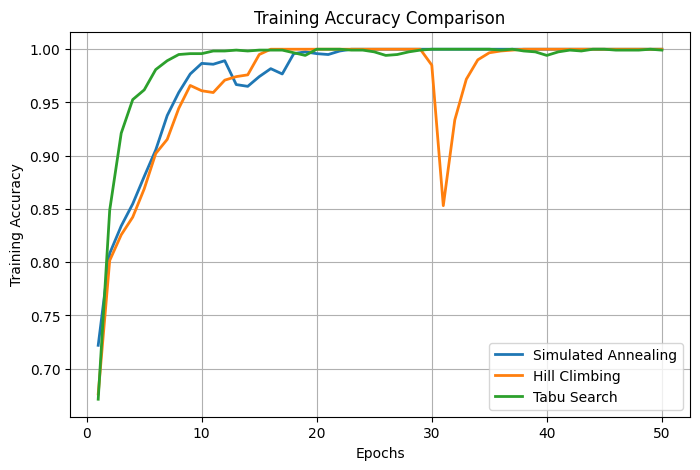

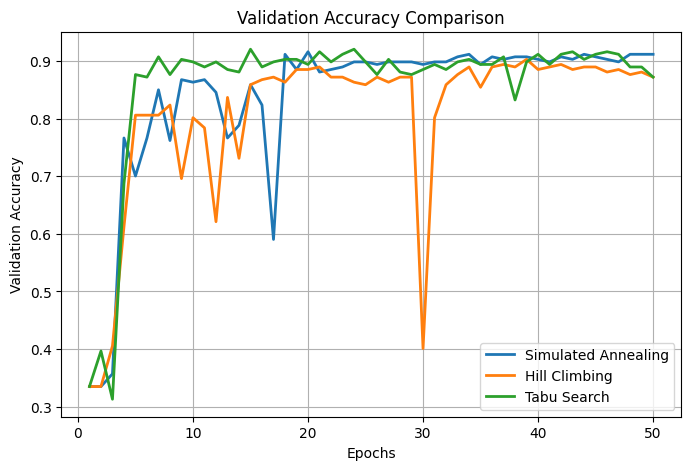

In [23]:
import matplotlib.pyplot as plt

train_acc_sim = history_sim['accuracy'] if isinstance(history_sim, dict) else history_sim.history['accuracy']
val_acc_sim = history_sim['val_accuracy'] if isinstance(history_sim, dict) else history_sim.history['val_accuracy']

train_acc_hill = history_hill['accuracy'] if isinstance(history_hill, dict) else history_hill.history['accuracy']
val_acc_hill = history_hill['val_accuracy'] if isinstance(history_hill, dict) else history_hill.history['val_accuracy']

train_acc_tabu = history_tabu['accuracy'] if isinstance(history_tabu, dict) else history_tabu.history['accuracy']
val_acc_tabu = history_tabu['val_accuracy'] if isinstance(history_tabu, dict) else history_tabu.history['val_accuracy']

epochs = range(1, len(train_acc_sim) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc_sim, label='Simulated Annealing', linewidth=2)
plt.plot(epochs, train_acc_hill, label='Hill Climbing', linewidth=2)
plt.plot(epochs, train_acc_tabu, label='Tabu Search', linewidth=2)
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, val_acc_sim, label='Simulated Annealing', linewidth=2)
plt.plot(epochs, val_acc_hill, label='Hill Climbing', linewidth=2)
plt.plot(epochs, val_acc_tabu, label='Tabu Search', linewidth=2)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
